## 전력사용량 예측 AI 경진대회


- 건물별 시간당 전력사용량을 예측하는 대회입니다.


- 건물별 전력사용량의 패턴을 파악하는게 핵심인 대회입니다.


- train data와 test data의 시간대가 다른, 시계열 문제입니다. 시계열 문제를 단순 회귀문제로 변환하여 푸는 방법을 알아봅니다.


- metric은 MAE를 사용합니다.


[Source] https://dacon.io/competitions/official/236125/overview/description

## 1. 라이브러리, 데이터 불러오기

In [ ]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from lightgbm.sklearn import LGBMRegressor  # sklearn API
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
def smape(gt, preds):
    gt= np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score

In [ ]:
# flag setting
feature_reducing = False # 'pca' or 'fi'
plot = False
evaluation_metric = mean_absolute_error

In [ ]:
# 데이터를 불러옵니다.
base_path = '/content/drive/MyDrive/Colab Notebooks/data/energy_usage_2023/'
train = pd.read_csv(base_path + 'train.csv')
building_info = pd.read_csv(base_path + 'building_info.csv')
test = pd.read_csv(base_path + 'test.csv')
print(train.shape, building_info.shape, test.shape)

(204000, 10) (100, 7) (16800, 7)


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.


### column 설명

- num_date_time(Primary Key) : 건물번호_시간

- 건물번호 : 1 ~ 100

- 일시 : 시간

- 기온, 강수량, 풍속, 습도, 일조, 일사 : 기상정보

- 전력소비량(target) : 건물별 시간당 전력소비량

In [ ]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 39.5 MB


In [ ]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [ ]:
## On your Own
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])
train.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity', 'target']
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity']

In [ ]:
#### TO-DO ####
# building_info에 있는 '-'를 모두 0으로 바꾸고, dtype을 float로 변경하세요.
# 1. replace
building_info = building_info.replace('-', 0)

# 2. loc
# for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
#     building_info.loc[building_info[col] == '-', col] = 0.0
# changing dtype
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    building_info[col] = building_info[col].astype(float)

building_info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,0.0,0.0,0.0
1,2,건물기타,122233.47,99000.00,0.0,0.0,0.0
2,3,건물기타,171243.00,113950.00,40.0,0.0,0.0
3,4,건물기타,74312.98,34419.62,60.0,0.0,0.0
4,5,건물기타,205884.00,150000.00,0.0,2557.0,1000.0
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0.0,0.0,0.0
96,97,호텔및리조트,55144.67,25880.00,0.0,0.0,0.0
97,98,호텔및리조트,53578.62,17373.75,0.0,0.0,0.0
98,99,호텔및리조트,53499.00,40636.00,0.0,0.0,0.0


<Axes: xlabel='date_time', ylabel='target'>

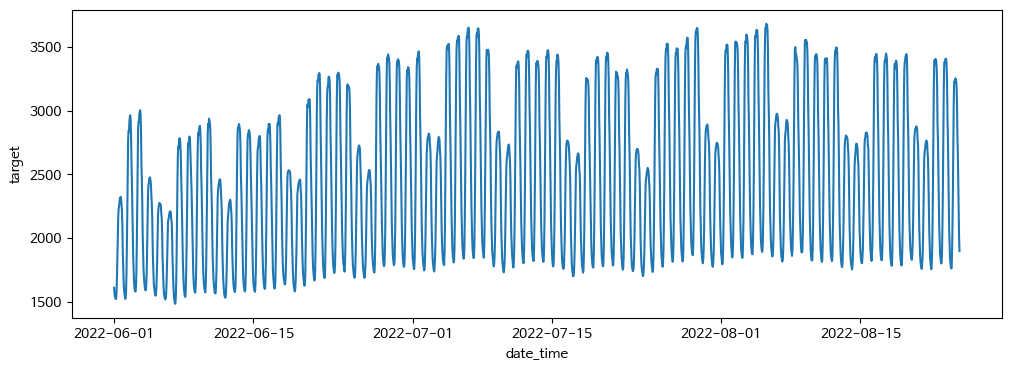

In [ ]:
# 전력사용량 패턴
#sns.histplot(data=train, x='target')
plt.figure(figsize=(12, 4))
train['date_time'] = pd.to_datetime(train['date_time']) # object -> datatime64[ns]
sns.lineplot(data=train, x='date_time', y='target', errorbar=None)

In [ ]:
building_info.columns = ['num', 'type', 'area', 'cooling_area', 'solar', 'ESS', 'PCS']

In [ ]:
# SQL JOIN (A JOIN B)
# on : 합칠 기준이 되는 column
# how : 'left'(A), 'inner'(A ^ B), 'outer'(A u B)
train = pd.merge(train, building_info, on='num', how='inner')
train

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,type,area,cooling_area,solar,ESS,PCS
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,1085.28,건물기타,110634.00,39570.00,0.0,0.0,0.0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,1047.36,건물기타,110634.00,39570.00,0.0,0.0,0.0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,974.88,건물기타,110634.00,39570.00,0.0,0.0,0.0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,953.76,건물기타,110634.00,39570.00,0.0,0.0,0.0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,986.40,건물기타,110634.00,39570.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,NaN,0.9,86.0,881.04,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,NaN,1.3,86.0,798.96,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,NaN,1.0,92.0,825.12,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,NaN,0.3,94.0,640.08,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0


In [ ]:
if plot:
    # 건물 유형별로 전력사용량 패턴 보기
    # for btype in train.type.unique():
    #     plt.figure(figsize=(12, 2))
    #     plt.title(btype)
    #     b = train[train.type == btype]
    #     sns.lineplot(data=b, x="date_time", y='target', errorbar=None)
    #     plt.show()

    # 건물별로 전력사용량 패턴 보기
    for bn in train.num.unique():
        plt.figure(figsize=(12, 2))
        plt.title(f'Building {bn}')
        b = train[train.num == bn]
        sns.lineplot(data=b, x="date_time", y='target', errorbar=None)
        plt.show()

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리


1) 모든 건물정보를 다 하나의 데이터에 넣고 하나의 모델로 예측.

- 건물정보를 feature로 넣겠다는 뜻.


2) 건물타입별로 데이터를 나누고, 각각의 모델로 예측.

- 건물타입은 주어진 타입을 사용할 수 있고, 직접 grouping해서 쓸 수도 있음.


3) 건물별로 데이터를 나누고, 각각의 모델로 예측. (모델이 100개)

#### 결측치 처리

In [ ]:
# 결측치가 있는 기상정보들의 결측치 채우기
## 강수량 - 결측치를 0으로 채우자.
## windspeed, humidity - interpolation(보간법)

train.precipitation = train.precipitation.fillna(0)
train.windspeed = train.windspeed.interpolate(method='linear')  #  27, (), (), 30 --> (1, 27) --- (4, 30) : y = x + 26
train.humidity = train.humidity.interpolate(method='linear')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  204000 non-null  float64       
 5   windspeed      204000 non-null  float64       
 6   humidity       204000 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area           204000 non-null  float64       
 10  cooling_area   204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [ ]:
# 건물 전체를 넣어서 모델링하기 위해 건물 타입을 categorical feature로 변환
train = pd.get_dummies(data=train, columns=['type'])
train

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,area,cooling_area,...,type_대학교,type_데이터센터,type_백화점및아울렛,type_병원,type_상용,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# time feature --> 월/일/시/요일
train['month'] = train.date_time.dt.month
train['day'] = train.date_time.dt.day
train['hour'] = train.date_time.dt.hour
train['dow'] = train.date_time.dt.day_of_week # 0 ~ 6 : 월~일

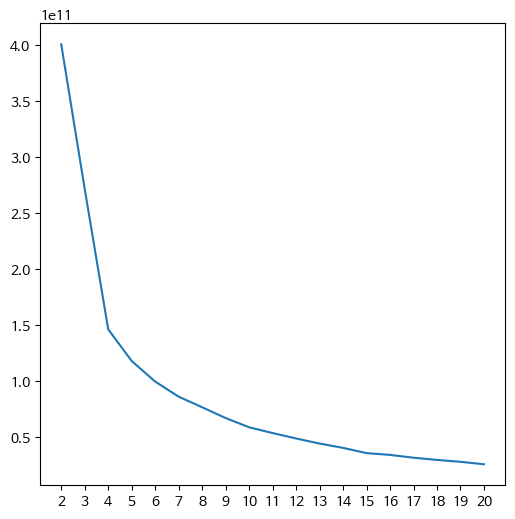

In [ ]:
# 전력사용량 clustering  ### 클러스터링을 하는 대상 : 100개 (204000 -> 100 ,,  2040 -> 1)
cluster_df = pd.DataFrame()

for bn in range(1, 101): # 1 ~ 100
    cluster_df[bn] = train.loc[train.num == bn, 'target'].values

cluster_df = cluster_df.T

# elbow method
krange = range(2, 21)
inertias = []
label_list = []
for K in krange:
    km = KMeans(n_clusters=K, n_init=30, random_state=42)
    labels = km.fit_predict(cluster_df) # 100 x 2040
    inertia = km.inertia_

    inertias.append(inertia)
    label_list.append(labels)

plt.figure(figsize=(6, 6))
plt.plot(krange, inertias)
plt.xticks(krange)
plt.show()

In [ ]:
# choose optimal K
optimal_k = 4
cluster_list = label_list[optimal_k-2]

In [ ]:
# group별 데이터 분할
cluster_df = pd.DataFrame({'num' : np.arange(1, 101),
                           'cluster' : cluster_list})
train = pd.merge(train, cluster_df, on='num')
train

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,area,cooling_area,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,cluster
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,...,0,0,0,0,0,6,1,0,2,2
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,...,0,0,0,0,0,6,1,1,2,2
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,...,0,0,0,0,0,6,1,2,2,2
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,...,0,0,0,0,0,6,1,3,2,2
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,...,0,0,0,0,0,6,1,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,...,0,0,0,0,1,8,24,19,2,0
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,...,0,0,0,0,1,8,24,20,2,0
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,...,0,0,0,0,1,8,24,21,2,0
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,...,0,0,0,0,1,8,24,22,2,0


### 4. 학습 데이터 분할

In [ ]:
def data_split(df, num, test_size=0.2, mode='train'):
    if mode == 'train':
        X = df[df.cluster == num].drop(columns=['num_date_time', 'date_time', 'target', 'cluster'])
        y = df[df.cluster == num].target

        # KFold-CV를 하면 이 방법론 자체에서 validation을 충분히 수행하기 때문에, validation data를 train_test_split을 통해서 나눌 필요가 없음.
        # OOF(Out-of-Fold) prediction는 KFold-CV에 사용하지 않은 작은 데이터로 최종 검증을 한번 해보는 방법.

        # 95%는 KFold-CV에 쓰고, 남은 5%는 OOF prediction에 사용.
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
        return X_train, X_val, y_train, y_val

    else: # for test
        X = df[df.cluster == num].drop(columns=['num_date_time', 'date_time', 'cluster'])
        print(X.shape)
        return X

### 5. 학습 및 평가

In [ ]:
# data = X_train, X_val, y_train, y_val
# data0 = data_split(train, 0)
# data1 = data_split(train, 1)
# data2 = data_split(train, 2)
# data3 = data_split(train, 3)

# for KFoldCV
data0 = data_split(train, 0, test_size=0.05)
data1 = data_split(train, 1, test_size=0.05)
data2 = data_split(train, 2, test_size=0.05)
data3 = data_split(train, 3, test_size=0.05)

(131784, 26) (131784,) (6936, 26) (6936,)
(1938, 26) (1938,) (102, 26) (102,)
(52326, 26) (52326,) (2754, 26) (2754,)
(7752, 26) (7752,) (408, 26) (408,)


In [ ]:
model0 = LGBMRegressor(max_depth=12, num_leaves=1023, colsample_bytree=0.5,
                       reg_lambda=5, learning_rate=0.3, n_estimators=100,
                       min_child_samples=20, random_state=42, importance_type='gain') # 104040
model1 = LGBMRegressor(max_depth=5, num_leaves=127, colsample_bytree=0.5,
                       reg_lambda=1, learning_rate=0.3, n_estimators=50,
                       min_child_samples=10, random_state=42, importance_type='gain')# 1530
model2 = LGBMRegressor(max_depth=10, num_leaves=1023, colsample_bytree=0.5,
                       reg_lambda=7, learning_rate=0.23, n_estimators=50,
                       min_child_samples=10, random_state=42, importance_type='gain')# 41310
model3 = LGBMRegressor(max_depth=7, num_leaves=511, colsample_bytree=0.5,
                       reg_lambda=5, learning_rate=0.2, n_estimators=50,
                       min_child_samples=10, random_state=42, importance_type='gain')# 6120

In [ ]:
def train_and_eval(model, data):
    # data[0] : X_train
    # data[1] : X_val
    # data[2] : y_train
    # data[3] : y_val
    model.fit(data[0], data[2])

    print("Average target value : %.4f" % np.mean(data[2]))
    print("Std target value : %.4f" % np.std(data[2]))
    mean_list = np.mean(data[2]) * np.ones(len(data[2]))
    print("Average absolute error : %.4f" % evaluation_metric(data[2], mean_list))

    print("Prediction")
    pred_train = model.predict(data[0])
    pred_val = model.predict(data[1])

    train_score = evaluation_metric(data[2], pred_train)
    val_score = evaluation_metric(data[3], pred_val)

    print("Train Score : %.4f" % train_score)
    print("Validation Score : %.4f" % val_score)

In [ ]:
train_and_eval(model0, data0)
train_and_eval(model1, data1)
train_and_eval(model2, data2)
train_and_eval(model3, data3)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 131784, number of used features: 26
[LightGBM] [Info] Start training from score 1510.451521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

### 6. Hyper-parameter Tuning

In [ ]:
def optimizer0(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [2**9-1, 2**10-1, 2**11-1])
    max_depth = trial.suggest_int('max_depth', 10, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 25)
    reg_lambda = trial.suggest_float('reg_lambda', 5.0, 20.0)
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.7])


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          reg_lambda=reg_lambda,
                          colsample_bytree=colsample_bytree,
                          random_state=42,
                          verbose=-1)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
def optimizer1(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [2**6-1, 2**7-1, 2**8-1])
    max_depth = trial.suggest_int('max_depth', 5, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 20, 50)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 25)
    reg_lambda = trial.suggest_float('reg_lambda', 5.0, 20.0)
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.7])


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          reg_lambda=reg_lambda,
                          colsample_bytree=colsample_bytree,
                          random_state=42,
                          verbose=-1)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
def optimizer2(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [2**9-1, 2**10-1, 2**11-1])
    max_depth = trial.suggest_int('max_depth', 8, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 25)
    reg_lambda = trial.suggest_float('reg_lambda', 5.0, 20.0)
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.7])


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          reg_lambda=reg_lambda,
                          colsample_bytree=colsample_bytree,
                          random_state=42,
                          verbose=-1)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
def optimizer3(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [2**7-1, 2**8-1, 2**9-1])
    max_depth = trial.suggest_int('max_depth', 10, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 25)
    reg_lambda = trial.suggest_float('reg_lambda', 5.0, 20.0)
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.7])


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          reg_lambda=reg_lambda,
                          colsample_bytree=colsample_bytree,
                          random_state=42,
                          verbose=-1)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = 5   # Kfold 수
# optimizer 함수에 parameter passing을 하고 싶은 경우.
opt_func = partial(optimizer0, X=data0[0], y=data0[2], K=K)

study0 = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study0.optimize(opt_func, n_trials=30)

[I 2023-11-29 09:02:32,332] A new study created in memory with name: no-name-4388db45-c6af-4574-89c3-7a35547bc211
[I 2023-11-29 09:03:21,693] Trial 0 finished with value: 143.5921187761324 and parameters: {'num_leaves': 511, 'max_depth': 11, 'learning_rate': 0.014786353642369469, 'n_estimators': 198, 'min_child_samples': 22, 'reg_lambda': 8.18977774978989, 'colsample_bytree': 0.7}. Best is trial 0 with value: 143.5921187761324.
[I 2023-11-29 09:03:41,728] Trial 1 finished with value: 114.5656787870269 and parameters: {'num_leaves': 511, 'max_depth': 13, 'learning_rate': 0.08313232041110036, 'n_estimators': 78, 'min_child_samples': 23, 'reg_lambda': 6.03017538195298, 'colsample_bytree': 0.5}. Best is trial 1 with value: 114.5656787870269.
[I 2023-11-29 09:04:34,570] Trial 2 finished with value: 80.05760162815605 and parameters: {'num_leaves': 1023, 'max_depth': 14, 'learning_rate': 0.04012276627324879, 'n_estimators': 169, 'min_child_samples': 24, 'reg_lambda': 10.816251877714308, 'cols

In [ ]:
K = 5   # Kfold 수
# optimizer 함수에 parameter passing을 하고 싶은 경우.
opt_func = partial(optimizer1, X=data1[0], y=data1[2], K=K)

study1 = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study1.optimize(opt_func, n_trials=30)

[I 2023-11-29 09:20:18,079] A new study created in memory with name: no-name-99abb7fa-144d-48ef-9b06-2d42f3aa2188
[I 2023-11-29 09:20:18,217] Trial 0 finished with value: 1384.2302815612106 and parameters: {'num_leaves': 127, 'max_depth': 6, 'learning_rate': 0.07483297064778577, 'n_estimators': 25, 'min_child_samples': 12, 'reg_lambda': 19.189781691411092, 'colsample_bytree': 0.5}. Best is trial 0 with value: 1384.2302815612106.
[I 2023-11-29 09:20:18,396] Trial 1 finished with value: 1151.1576826028663 and parameters: {'num_leaves': 255, 'max_depth': 7, 'learning_rate': 0.06984293668390064, 'n_estimators': 39, 'min_child_samples': 18, 'reg_lambda': 16.941479836943955, 'colsample_bytree': 0.5}. Best is trial 1 with value: 1151.1576826028663.
[I 2023-11-29 09:20:18,552] Trial 2 finished with value: 1224.204690855714 and parameters: {'num_leaves': 63, 'max_depth': 7, 'learning_rate': 0.04089519692271081, 'n_estimators': 33, 'min_child_samples': 21, 'reg_lambda': 17.796907330400376, 'cols

In [ ]:
K = 5   # Kfold 수
opt_func = partial(optimizer2, X=data2[0], y=data2[2], K=K)

study2 = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study2.optimize(opt_func, n_trials=30)

[I 2023-11-29 09:20:26,134] A new study created in memory with name: no-name-bccc15f4-8464-49e4-8bf7-48aaa86f1d9c
[I 2023-11-29 09:20:31,928] Trial 0 finished with value: 575.6204482854267 and parameters: {'num_leaves': 2047, 'max_depth': 13, 'learning_rate': 0.012247398646239641, 'n_estimators': 76, 'min_child_samples': 21, 'reg_lambda': 17.327879588709955, 'colsample_bytree': 0.5}. Best is trial 0 with value: 575.6204482854267.
[I 2023-11-29 09:20:44,997] Trial 1 finished with value: 262.16229745941774 and parameters: {'num_leaves': 2047, 'max_depth': 12, 'learning_rate': 0.02142669294284624, 'n_estimators': 127, 'min_child_samples': 25, 'reg_lambda': 5.915811637134359, 'colsample_bytree': 0.5}. Best is trial 1 with value: 262.16229745941774.
[I 2023-11-29 09:20:51,138] Trial 2 finished with value: 139.05108386486836 and parameters: {'num_leaves': 511, 'max_depth': 10, 'learning_rate': 0.07583242493532354, 'n_estimators': 97, 'min_child_samples': 23, 'reg_lambda': 18.342060410744676,

In [ ]:
K = 5   # Kfold 수
# optimizer 함수에 parameter passing을 하고 싶은 경우.
opt_func = partial(optimizer3, X=data3[0], y=data3[2], K=K)

study3 = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study3.optimize(opt_func, n_trials=30)

[I 2023-11-29 09:29:27,241] A new study created in memory with name: no-name-3608fff7-52de-4862-8423-a5569b8cc7ea
[I 2023-11-29 09:29:28,161] Trial 0 finished with value: 392.6610439618994 and parameters: {'num_leaves': 127, 'max_depth': 15, 'learning_rate': 0.02704538741504607, 'n_estimators': 111, 'min_child_samples': 25, 'reg_lambda': 13.694140712966192, 'colsample_bytree': 0.5}. Best is trial 0 with value: 392.6610439618994.
[I 2023-11-29 09:29:31,435] Trial 1 finished with value: 152.33560910831847 and parameters: {'num_leaves': 511, 'max_depth': 13, 'learning_rate': 0.03450219983503164, 'n_estimators': 185, 'min_child_samples': 11, 'reg_lambda': 19.628425456615965, 'colsample_bytree': 0.7}. Best is trial 1 with value: 152.33560910831847.
[I 2023-11-29 09:29:33,030] Trial 2 finished with value: 231.58123229686765 and parameters: {'num_leaves': 127, 'max_depth': 15, 'learning_rate': 0.03404410053673439, 'n_estimators': 102, 'min_child_samples': 18, 'reg_lambda': 14.122830519210341,

In [ ]:
def display_experiments(study):
    print("Best Score: %.4f" % study.best_value) # best score 출력
    print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들
    display(study.trials_dataframe())
    optuna.visualization.plot_optimization_history(study)
    optuna.visualization.plot_param_importances(study)

In [ ]:
display_experiments(study0)

Best Score: 69.7297
Best params:  {'num_leaves': 2047, 'max_depth': 15, 'learning_rate': 0.09956734531670162, 'n_estimators': 196, 'min_child_samples': 18, 'reg_lambda': 18.46671902628782, 'colsample_bytree': 0.7}


,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_lambda,state
0,0,143.592119,2023-11-29 09:02:32.334533,2023-11-29 09:03:21.692939,0 days 00:00:49.358406,0.7,0.014786,11,22,198,511,8.189778,COMPLETE
1,1,114.565679,2023-11-29 09:03:21.698738,2023-11-29 09:03:41.727701,0 days 00:00:20.028963,0.5,0.083132,13,23,78,511,6.030175,COMPLETE
2,2,80.057602,2023-11-29 09:03:41.730267,2023-11-29 09:04:34.570236,0 days 00:00:52.839969,0.7,0.040123,14,24,169,1023,10.816252,COMPLETE
3,3,101.724423,2023-11-29 09:04:34.572099,2023-11-29 09:04:48.144423,0 days 00:00:13.572324,0.7,0.088295,10,17,72,1023,9.833150,COMPLETE
4,4,108.052824,2023-11-29 09:04:48.146329,2023-11-29 09:05:09.277936,0 days 00:00:21.131607,0.5,0.098894,14,13,65,2047,6.856711,COMPLETE
5,5,120.965852,2023-11-29 09:05:09.280194,2023-11-29 09:05:23.782851,0 days 00:00:14.502657,0.7,0.044748,15,17,74,511,15.543399,COMPLETE
6,6,104.283040,2023-11-29 09:05:23.785282,2023-11-29 09:06:01.541807,0 days 00:00:37.756525,0.7,0.025698,14,10,153,1023,18.801227,COMPLETE
7,7,121.679531,2023-11-29 09:06:01.548003,2023-11-29 09:06:22.654348,0 days 00:00:21.106345,0.7,0.040505,14,24,83,2047,18.578777,COMPLETE
8,8,84.563164,2023-11-29 09:06:22.659886,2023-11-29 09:06:43.397978,0 days 00:00:20.738092,0.7,0.086904,11,13,124,511,15.377361,COMPLETE
9,9,100.247510,2023-11-29 09:06:43.399831,2023-11-29 09:07:00.099540,0 days 00:00:16.699709,0.5,0.095969,14,14,95,511,7.462146,COMPLETE


In [ ]:
display_experiments(study1)

Best Score: 373.7948
Best params:  {'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.09365756541432775, 'n_estimators': 49, 'min_child_samples': 15, 'reg_lambda': 7.828753195444996, 'colsample_bytree': 0.7}


,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_lambda,state
0,0,1384.230282,2023-11-29 09:20:18.084515,2023-11-29 09:20:18.216590,0 days 00:00:00.132075,0.5,0.074833,6,12,25,127,19.189782,COMPLETE
1,1,1151.157683,2023-11-29 09:20:18.220280,2023-11-29 09:20:18.396326,0 days 00:00:00.176046,0.5,0.069843,7,18,39,255,16.941480,COMPLETE
2,2,1224.204691,2023-11-29 09:20:18.399358,2023-11-29 09:20:18.552047,0 days 00:00:00.152689,0.7,0.040895,7,21,33,63,17.796907,COMPLETE
3,3,1746.533772,2023-11-29 09:20:18.555017,2023-11-29 09:20:18.673005,0 days 00:00:00.117988,0.5,0.039016,5,25,27,127,13.641771,COMPLETE
4,4,1516.049602,2023-11-29 09:20:18.676015,2023-11-29 09:20:18.892571,0 days 00:00:00.216556,0.7,0.018208,6,11,49,63,8.956729,COMPLETE
5,5,1070.039800,2023-11-29 09:20:18.898031,2023-11-29 09:20:19.051525,0 days 00:00:00.153494,0.7,0.053718,5,24,29,255,10.079282,COMPLETE
6,6,1427.181892,2023-11-29 09:20:19.058400,2023-11-29 09:20:19.203735,0 days 00:00:00.145335,0.5,0.087823,9,12,21,63,10.791216,COMPLETE
7,7,1155.329181,2023-11-29 09:20:19.210362,2023-11-29 09:20:19.405757,0 days 00:00:00.195395,0.5,0.074808,7,13,37,127,12.177214,COMPLETE
8,8,994.067916,2023-11-29 09:20:19.411966,2023-11-29 09:20:19.579830,0 days 00:00:00.167864,0.7,0.048552,6,21,35,63,14.822504,COMPLETE
9,9,2008.977819,2023-11-29 09:20:19.585056,2023-11-29 09:20:19.748462,0 days 00:00:00.163406,0.5,0.021620,6,12,33,255,11.560859,COMPLETE


In [ ]:
display_experiments(study2)

Best Score: 105.4479
Best params:  {'num_leaves': 2047, 'max_depth': 15, 'learning_rate': 0.09904495824337373, 'n_estimators': 200, 'min_child_samples': 15, 'reg_lambda': 15.093373382697864, 'colsample_bytree': 0.7}


,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_lambda,state
0,0,575.620448,2023-11-29 09:20:26.136860,2023-11-29 09:20:31.927869,0 days 00:00:05.791009,0.5,0.012247,13,21,76,2047,17.327880,COMPLETE
1,1,262.162297,2023-11-29 09:20:31.929772,2023-11-29 09:20:44.996717,0 days 00:00:13.066945,0.5,0.021427,12,25,127,2047,5.915812,COMPLETE
2,2,139.051084,2023-11-29 09:20:44.998582,2023-11-29 09:20:51.138262,0 days 00:00:06.139680,0.7,0.075832,10,23,97,511,18.342060,COMPLETE
3,3,243.791698,2023-11-29 09:20:51.141254,2023-11-29 09:20:58.242372,0 days 00:00:07.101118,0.5,0.039379,10,24,85,1023,5.745956,COMPLETE
4,4,174.791606,2023-11-29 09:20:58.244569,2023-11-29 09:21:06.961795,0 days 00:00:08.717226,0.5,0.033929,9,12,179,511,11.634562,COMPLETE
5,5,116.362740,2023-11-29 09:21:06.964839,2023-11-29 09:21:17.888484,0 days 00:00:10.923645,0.7,0.082464,14,13,104,511,12.162792,COMPLETE
6,6,113.881124,2023-11-29 09:21:17.890317,2023-11-29 09:21:41.342474,0 days 00:00:23.452157,0.7,0.047671,13,19,189,2047,12.301699,COMPLETE
7,7,261.305499,2023-11-29 09:21:41.345517,2023-11-29 09:21:47.379569,0 days 00:00:06.034052,0.5,0.036666,8,25,101,1023,16.297238,COMPLETE
8,8,116.674891,2023-11-29 09:21:47.381676,2023-11-29 09:22:01.280595,0 days 00:00:13.898919,0.7,0.068597,12,12,140,1023,17.021130,COMPLETE
9,9,162.663533,2023-11-29 09:22:01.287315,2023-11-29 09:22:09.275526,0 days 00:00:07.988211,0.7,0.037083,8,12,168,2047,10.313174,COMPLETE


In [ ]:
display_experiments(study3)

Best Score: 124.7811
Best params:  {'num_leaves': 255, 'max_depth': 15, 'learning_rate': 0.08692949447196749, 'n_estimators': 200, 'min_child_samples': 24, 'reg_lambda': 6.2959497801790745, 'colsample_bytree': 0.7}


,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_lambda,state
0,0,392.661044,2023-11-29 09:29:27.244231,2023-11-29 09:29:28.161362,0 days 00:00:00.917131,0.5,0.027045,15,25,111,127,13.694141,COMPLETE
1,1,152.335609,2023-11-29 09:29:28.163500,2023-11-29 09:29:31.435247,0 days 00:00:03.271747,0.7,0.034502,13,11,185,511,19.628425,COMPLETE
2,2,231.581232,2023-11-29 09:29:31.438357,2023-11-29 09:29:33.029960,0 days 00:00:01.591603,0.7,0.034044,15,18,102,127,14.122831,COMPLETE
3,3,217.174058,2023-11-29 09:29:33.036438,2023-11-29 09:29:34.535592,0 days 00:00:01.499154,0.7,0.040733,12,22,96,511,18.840086,COMPLETE
4,4,174.099661,2023-11-29 09:29:34.538609,2023-11-29 09:29:38.321035,0 days 00:00:03.782426,0.7,0.022329,15,14,199,255,7.748555,COMPLETE
5,5,318.663551,2023-11-29 09:29:38.323530,2023-11-29 09:29:38.982372,0 days 00:00:00.658842,0.5,0.062935,12,17,53,511,5.742858,COMPLETE
6,6,248.830720,2023-11-29 09:29:38.984504,2023-11-29 09:29:40.672681,0 days 00:00:01.688177,0.7,0.020943,11,13,150,255,13.527852,COMPLETE
7,7,132.484451,2023-11-29 09:29:40.674368,2023-11-29 09:29:42.707728,0 days 00:00:02.033360,0.7,0.053702,12,13,169,127,12.140534,COMPLETE
8,8,131.246096,2023-11-29 09:29:42.710120,2023-11-29 09:29:44.702684,0 days 00:00:01.992564,0.7,0.068945,10,10,155,511,13.747577,COMPLETE
9,9,135.318766,2023-11-29 09:29:44.704539,2023-11-29 09:29:46.429935,0 days 00:00:01.725396,0.7,0.056713,11,12,146,127,10.840990,COMPLETE


In [ ]:
def model_finalization(data, study):
    # model finalization
    best_params = study.best_params
    best_model = LGBMRegressor(**best_params,
                            random_state=42,
                            verbose=-1)
    best_model.fit(data[0], data[2])
    print("Validation MAE : %.4f" % evaluation_metric(data[3], best_model.predict(data[1])))
    return best_model

In [ ]:
def view_feature_importances(best_model):
    fi_df = pd.DataFrame({'features' : best_model.feature_name_,
                        'importances' : best_model.feature_importances_})
    fi_df.sort_values(by='importances', ascending=False)
    display(fi_df)

### 7. 테스트 및 제출 파일 생성

In [ ]:
test

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [ ]:
## TO-DO ##
# X_test 만들기 : 앞서했던 전처리를 동일하게 적용해주면 됨.
# SQL JOIN (A JOIN B)
# on : 합칠 기준이 되는 column
# how : 'left'(A), 'inner'(A ^ B), 'outer'(A u B)\
X_test = test.copy()
X_test = pd.merge(X_test, building_info, on='num', how='inner')
# 건물 전체를 넣어서 모델링하기 위해 건물 타입을 categorical feature로 변환
X_test = pd.get_dummies(data=X_test, columns=['type'])
# time feature --> 월/일/시/요일
X_test.date_time = pd.to_datetime(X_test.date_time)
X_test['month'] = X_test.date_time.dt.month
X_test['day'] = X_test.date_time.dt.day
X_test['hour'] = X_test.date_time.dt.hour
X_test['dow'] = X_test.date_time.dt.day_of_week # 0 ~ 6 : 월~일
X_test = pd.merge(X_test, cluster_df, on='num')
X_test

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,area,cooling_area,solar,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,cluster
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,110634.00,39570.00,0.0,...,0,0,0,0,0,8,25,0,3,2
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,110634.00,39570.00,0.0,...,0,0,0,0,0,8,25,1,3,2
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,110634.00,39570.00,0.0,...,0,0,0,0,0,8,25,2,3,2
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,110634.00,39570.00,0.0,...,0,0,0,0,0,8,25,3,3,2
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,110634.00,39570.00,0.0,...,0,0,0,0,0,8,25,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100_20220831 19,100,2022-08-31 19:00:00,22.5,0.0,0.9,84,57497.84,40035.23,0.0,...,0,0,0,0,1,8,31,19,2,0
16796,100_20220831 20,100,2022-08-31 20:00:00,20.7,0.0,0.4,95,57497.84,40035.23,0.0,...,0,0,0,0,1,8,31,20,2,0
16797,100_20220831 21,100,2022-08-31 21:00:00,20.2,0.0,0.4,98,57497.84,40035.23,0.0,...,0,0,0,0,1,8,31,21,2,0
16798,100_20220831 22,100,2022-08-31 22:00:00,20.1,0.0,1.1,97,57497.84,40035.23,0.0,...,0,0,0,0,1,8,31,22,2,0


In [ ]:
# use 4 models in each group
test0 = data_split(X_test, 0, mode='test')
test1 = data_split(X_test, 1, mode='test')
test2 = data_split(X_test, 2, mode='test')
test3 = data_split(X_test, 3, mode='test')

(11424, 26)
(168, 26)
(4536, 26)
(672, 26)


In [ ]:
# model prediction
pred0 = model0.predict(test0)
pred1 = model1.predict(test1)
pred2 = model2.predict(test2)
pred3 = model3.predict(test3)
print(pred0.shape, pred1.shape, pred2.shape, pred3.shape)

(11424,) (168,) (4536,) (672,)


In [ ]:
submission = pd.read_csv(base_path + 'sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [ ]:
submission.loc[test0.index, 'answer'] = pred0
submission.loc[test1.index, 'answer'] = pred1
submission.loc[test2.index, 'answer'] = pred2
submission.loc[test3.index, 'answer'] = pred3

In [ ]:
submission

,num_date_time,answer
0,1_20220825 00,2037.768168
1,1_20220825 01,1928.252358
2,1_20220825 02,1905.335562
3,1_20220825 03,1718.147239
4,1_20220825 04,1714.580181
...,...,...
16795,100_20220831 19,1056.702241
16796,100_20220831 20,780.598919
16797,100_20220831 21,742.849936
16798,100_20220831 22,766.785916


In [ ]:
submission.to_csv("submission.csv", index=False)